In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrix, dmatrices
import seaborn as sns
sns.set()

In [2]:
TREAT_STATES_YEARS = {"AZ": 2006, "CA": 2002, "CO": 2004, "CT": 1998, "DE": 2005, "HI": 2001, "IL": 2007, "IN": 2011, "IA": 1983, "KS": 2009, "ME": 1999, "MD": 2004, "MA": 1997, "MI": 2008, "MN": 2007, "MO": 2007, "MT": 2005, "NV": 1997, "NH": 2007, "NJ": 1991, "NM": 2002, "NY": 2004, "NC": 2007, "ND": 2007, "OH": 2008, "OK": 2010, "OR": 2007, "PA": 2004, "RI": 2004, "SC": 2014, "SD": 2008, "TX": 1999, "UT": 2008, "VT": 2005, "VA": 2007, "WA": 2006, "WV": 2009, "WI": 1998, "DC": 2005}
TREAT_STATES = set(TREAT_STATES_YEARS.keys())
CTRL_STATES = {"GA", "KY", "ID", "AL", "MS", "FL", "LA", "WY", "TN", "NE", "AK", "AR"}
ALL_STATES = TREAT_STATES | CTRL_STATES

In [3]:
full_df = pd.read_csv("Datasets/seds.csv")
orig_num_rows = full_df.shape[0]
full_df.dropna(inplace=True)

print("Dropped {} rows".format(orig_num_rows - full_df.shape[0]))
print(full_df.shape)
display.display(full_df.describe())
display.display(full_df.head(10))

Dropped 28158 rows
(1683578, 8)


,year,value
count,1.683578e+06,1.683578e+06
mean,1.990484e+03,1.077022e+05
std,1.567905e+01,1.383675e+06
min,1.960000e+03,-7.090800e+05
25%,1.977000e+03,1.033000e+00
50%,1.991000e+03,8.400000e+01
75%,2.004000e+03,6.942000e+03
max,2.017000e+03,1.009913e+08


,year,msn,state_name,state_code,description,energy_bin,value,unit
0,1960,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
1,1961,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
2,1962,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
3,1963,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
4,1964,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
5,1965,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
6,1966,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
7,1967,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
8,1968,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu
9,1969,ABICB,Alaska,AK,Aviation gasoline blending components consumed...,Petroleum,0.0,Billion Btu


In [4]:
# asphalt_output = full_df.loc[full_df["msn"] == "ESTCB"]
# display.display(asphalt_output.groupby("state_code")["value"].mean())

In [5]:
full_df["year_categ"] = full_df["year"].astype("category")

# time-fixed effects
year_df = pd.DataFrame()
year_df["year_categ"] = full_df["year_categ"].unique()
year_df["year_categ"] = year_df["year_categ"].astype("category")
year_df["key"] = 0

# unit-fixed effects
state_df = pd.DataFrame()
state_df["state_code"] = list(ALL_STATES)
state_df["state_code"] = state_df["state_code"].astype("category")
state_df["key"] = 0

# treatment indicator
regressors_df = pd.merge(year_df, state_df, on="key")
regressors_df.drop("key", axis=1, inplace=True)
regressors_df["treated"] = regressors_df.apply(
        lambda r: r["state_code"] in TREAT_STATES and r["year_categ"] > TREAT_STATES_YEARS[r["state_code"]],
        axis=1)
regressors_df.sort_values(["state_code", "year_categ"], inplace=True)
regressors_df.reset_index(drop=True, inplace=True)

In [6]:
def preprocess(target_msn):
    target_df = full_df[full_df["msn"] == target_msn][["state_code", "year_categ", "value"]]
#     target_df["value"] = np.log(target_df)
    target_df.sort_values(["state_code", "year_categ"], inplace=True)
    target_df.reset_index(drop=True, inplace=True)

    prepped_df = pd.merge(regressors_df, target_df, on=["state_code", "year_categ"], sort=True)
    display.display(prepped_df.head(10))
    
    return prepped_df, target_df

In [7]:
def fit_model(df):
    y, X = dmatrices("value ~ year_categ + state_code + treated", data=prepped_df, return_type="dataframe")
    model = sm.RLM(y, X)
    res = model.fit()
    return res

In [8]:
def visualize_predictions(results, target_df, state_code, start_year):
    df_policy = regressors_df[(regressors_df["year_categ"].astype("int") >= start_year) & (regressors_df["state_code"] == state_code)]
    df_nopolicy = df_policy.copy()
    df_nopolicy["treated"] = False
    target_df = target_df[(target_df["year_categ"].astype("int") >= start_year) & (target_df["state_code"] == state_code)]
    
    policy_predictions = results.predict(dmatrix("year_categ + state_code + treated", data=df_policy, return_type="dataframe"))
    nopolicy_predictions = results.predict(dmatrix("year_categ + state_code + treated", data=df_nopolicy, return_type="dataframe"))
    plt.plot(list(df_policy["year_categ"]), list(policy_predictions), label="Predictions with policy")
    plt.plot(list(df_nopolicy["year_categ"]), list(nopolicy_predictions), label="Predictions without policy")
    plt.plot(list(target_df["year_categ"]), list(target_df["value"]), label="Actual")
    plt.legend()
    plt.title("Results for {}".format(state_code))
    plt.show()

In [9]:
def visualize_nopolicy_prediction(results, target_df, state_code, start_year):
    target_df = target_df[(target_df["year_categ"].astype("int") >= start_year) & (target_df["state_code"] == state_code)]
    nopolicy_df = target_df.copy()
    nopolicy_df.loc[nopolicy_df["year_categ"].astype("int") > TREAT_STATES_YEARS[state_code], "value"] -= results.params[-1]
    
    plt.plot(list(target_df["year_categ"]), list(target_df["value"]), label="Actual (with policy)")
    plt.plot(list(nopolicy_df["year_categ"]), list(nopolicy_df["value"]), label="Predictions without policy")
    plt.legend()
    plt.title("Results for {}".format(state_code))
    plt.show()

In [10]:
def visualize_policy_prediction(results, target_df, state_code, start_year):
    target_df = target_df[(target_df["year_categ"].astype("int") >= start_year) & (target_df["state_code"] == state_code)]
    policy_df = target_df.copy()
    policy_df.loc[policy_df["year_categ"].astype("int") > 2000, "value"] += results.params[-1]
    
    plt.plot(list(target_df["year_categ"]), list(target_df["value"]), label="Actual (without policy)")
    plt.plot(list(policy_df["year_categ"]), list(policy_df["value"]), label="Predictions with policy")
    plt.legend()
    plt.title("Results for {}".format(state_code))
    plt.show()

,year_categ,state_code,treated,value
0,1960,AK,False,1011.0
1,1961,AK,False,1175.0
2,1962,AK,False,1359.0
3,1963,AK,False,1649.0
4,1964,AK,False,1824.0
5,1965,AK,False,2107.0
6,1966,AK,False,2365.0
7,1967,AK,False,2533.0
8,1968,AK,False,2863.0
9,1969,AK,False,3201.0


                    Robust linear Model Regression Results                    
Dep. Variable:                  value   No. Observations:                 2958
Model:                            RLM   Df Residuals:                     2849
Method:                          IRLS   Df Model:                          108
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 18 Mar 2019                                         
Time:                        16:19:43                                         
No. Iterations:                     5                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -8.89e+04   7749

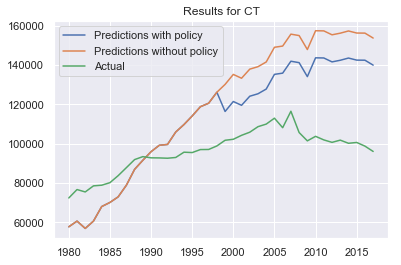

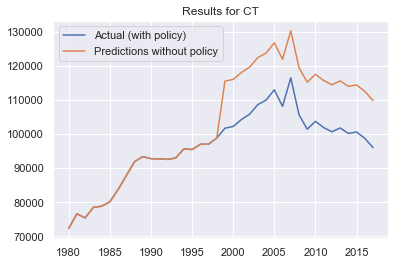

In [11]:
prepped_df, target_df = preprocess("ESTCB")
res = fit_model(prepped_df)
print(res.summary())
visualize_predictions(res, target_df, "CT", 1980)
visualize_nopolicy_prediction(res, target_df, "CT", 1980)

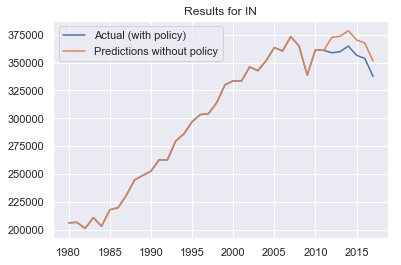

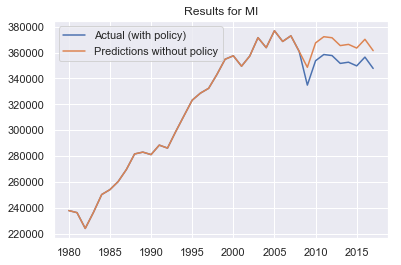

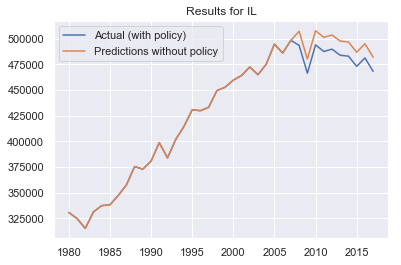

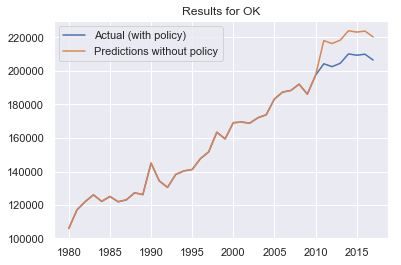

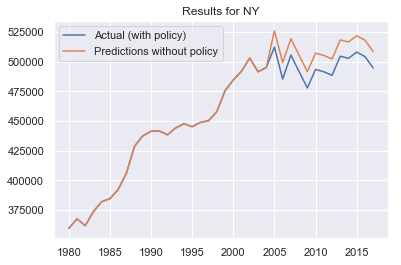

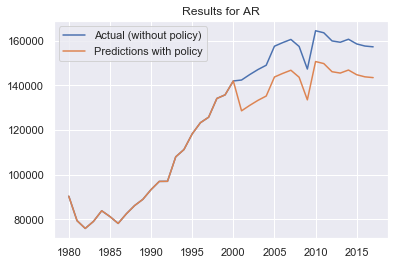

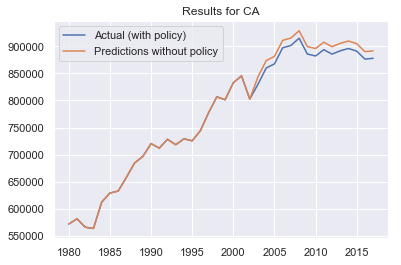

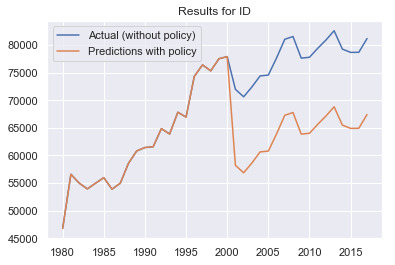

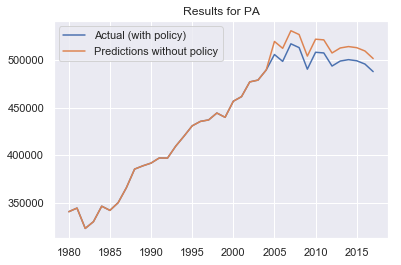

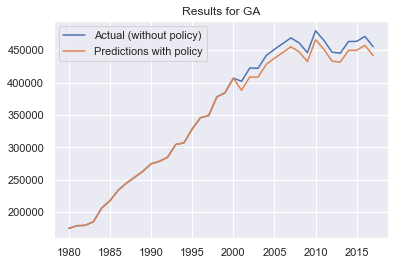

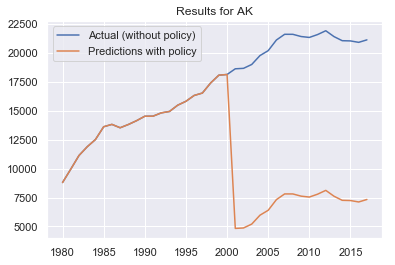

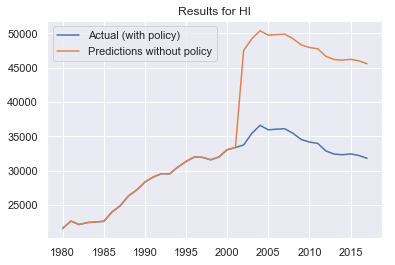

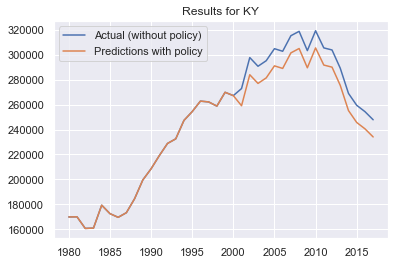

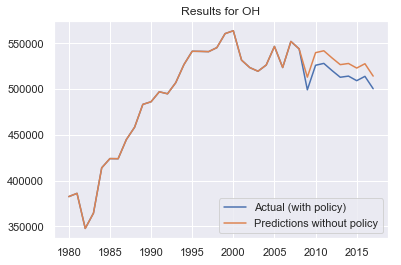

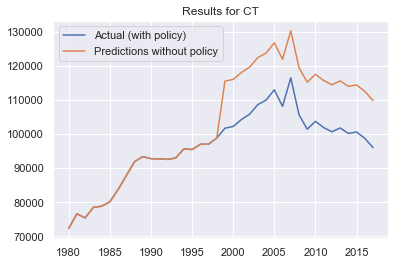

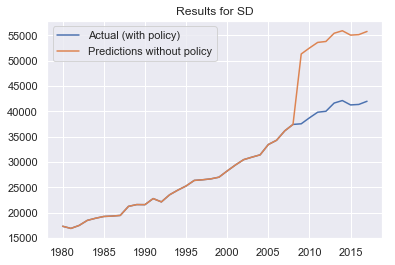

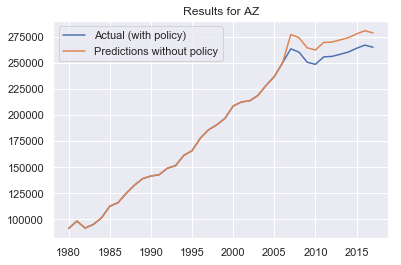

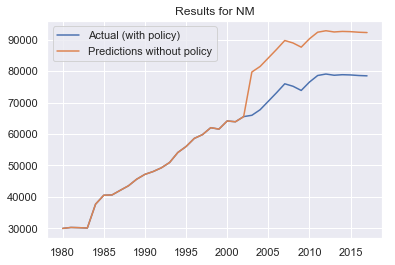

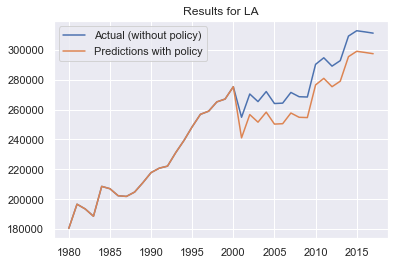

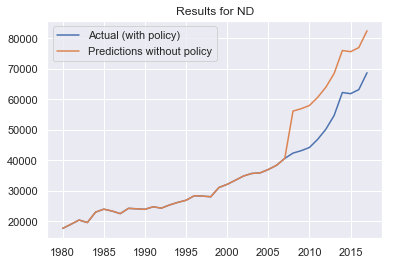

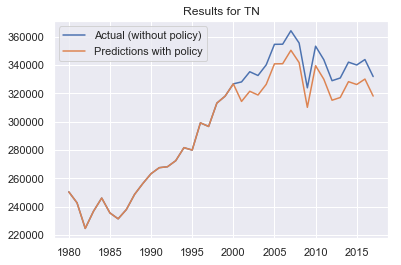

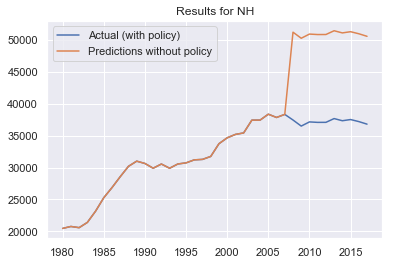

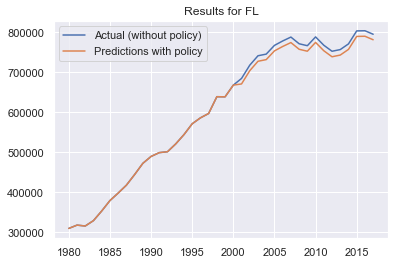

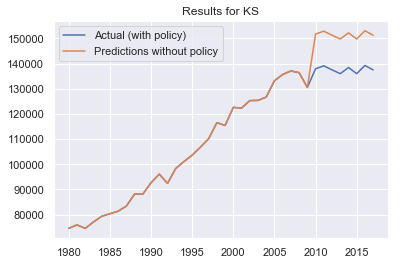

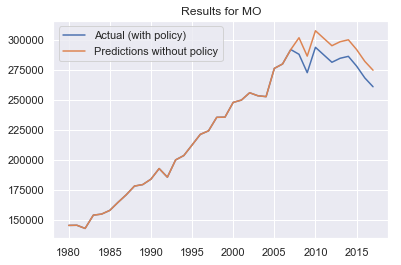

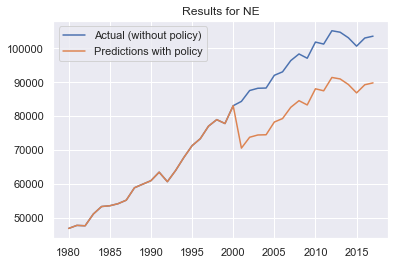

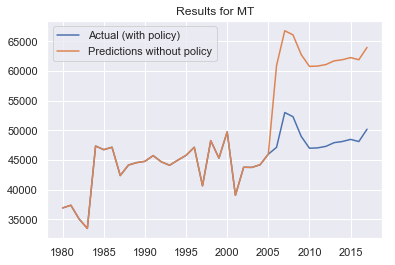

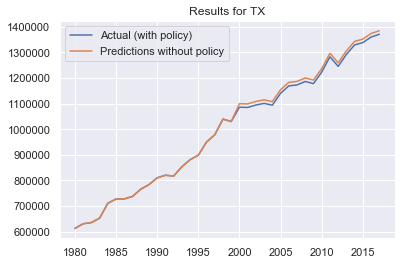

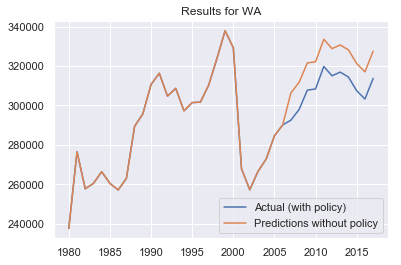

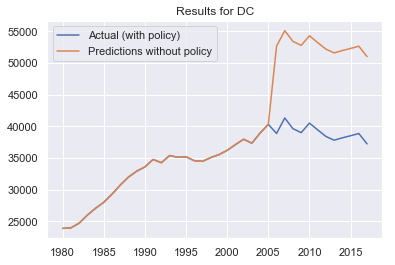

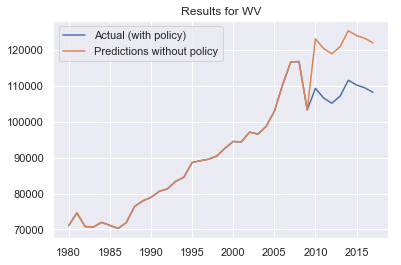

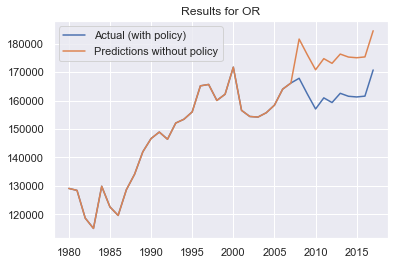

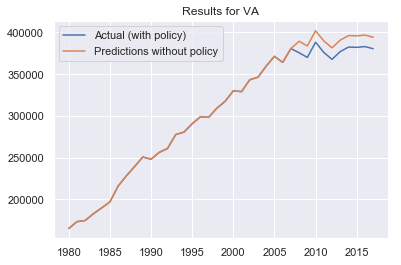

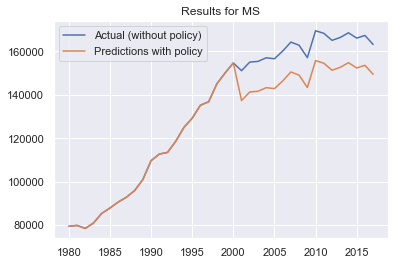

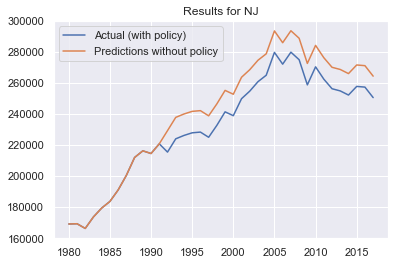

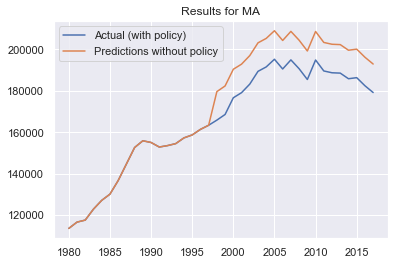

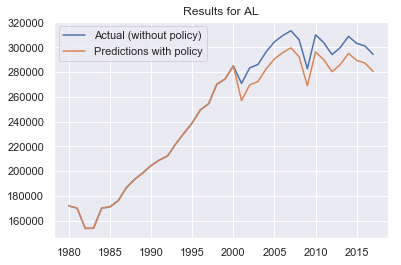

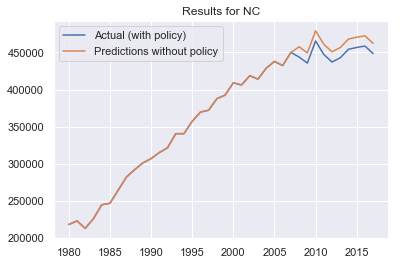

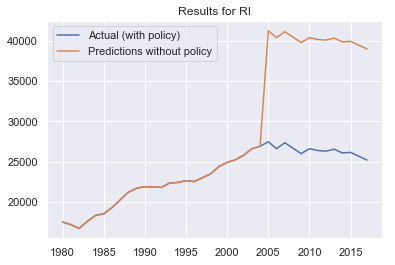

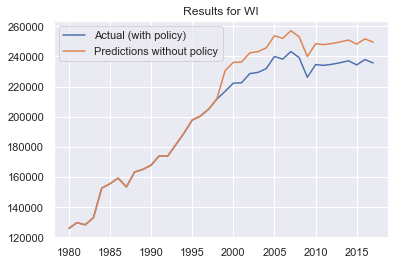

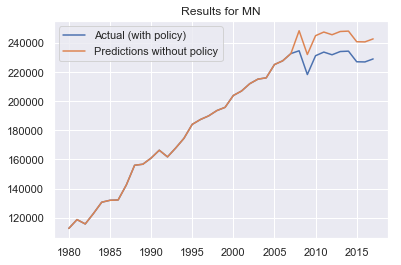

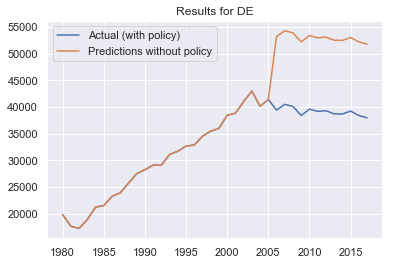

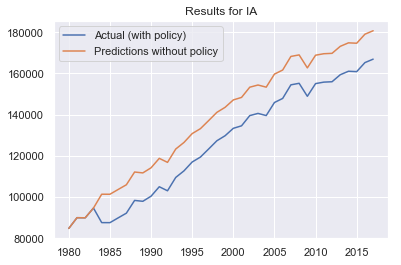

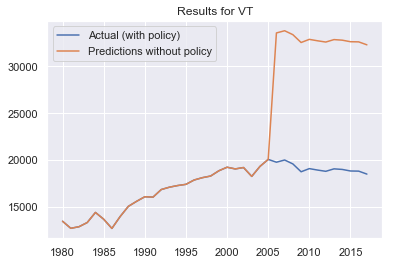

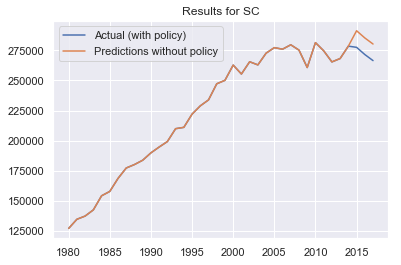

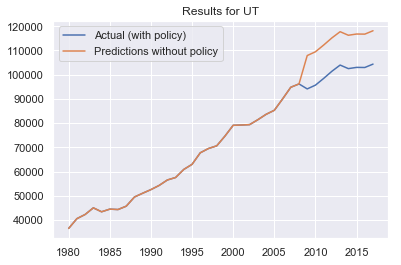

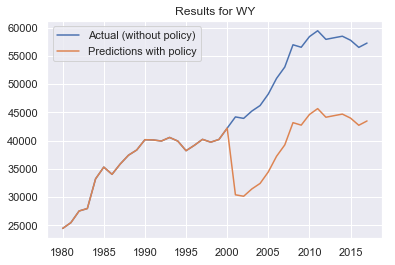

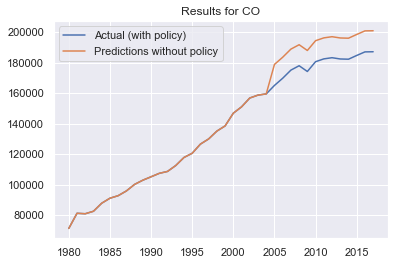

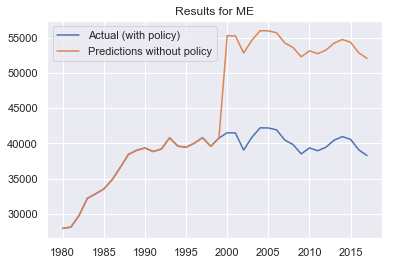

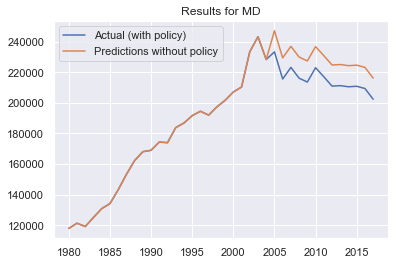

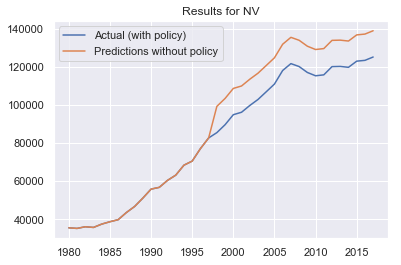

In [12]:
for state_code in ALL_STATES:
    if state_code in TREAT_STATES:
        visualize_nopolicy_prediction(res, target_df, state_code, 1980)
    else:
        visualize_policy_prediction(res, target_df, state_code, 1980)

In [14]:
MSN_INPUT = ['ARTCP','ARTCB','ARTCD','ARTCV','JFTCP','JFTCB','JFTCD','JFTCV','MGCCP','MGICP','MGACP','MGTCP','MGCCB','MGICB','MGACB','MGTCB','MGTCD','MGCCV','MGACV','MGTCV','ENACP','ENCCP','ENICP','ENTCP','EMACB','EMCCB','EMICB','EMTCB','AVTCP','AVTCD','AVTCV','LUCIP','LUACP','LUTCP','LUICB','LUACB','DFRCP','DFCCP','DFICP','DFACP','DFEIP','DFTCP','DFRCB','DFCCB','DFICB','DFACB','DFEIB','DFTCB','RFCCP','RFICP','RFACP','RFEIP','RFTCP','RFCCB','RFICB','RFACB','RFEIB','RFTCB']
MSN_INPUT_SMALL = ['ARTCB','ESTCB']
MSN_INPUT = ['ARTCP','ARTCB','ARTCD','ARTCV','JFTCP','JFTCB','JFTCD','JFTCV','MGCCP','MGICP','MGACP']

d = []
for i in MSN_INPUT:
    prepped_df, target_df = preprocess(i)
    res = fit_model(prepped_df)
    d.append((i, res.params[-1], res.pvalues[-1]))
pd.DataFrame(d, columns=('msn', 'coff', 'pvalues'))
d

,year_categ,state_code,treated,value
0,1960,AK,False,47.0
1,1961,AK,False,84.0
2,1962,AK,False,74.0
3,1963,AK,False,89.0
4,1964,AK,False,119.0
5,1965,AK,False,132.0
6,1966,AK,False,248.0
7,1967,AK,False,125.0
8,1968,AK,False,114.0
9,1969,AK,False,146.0


,year_categ,state_code,treated,value
0,1960,AK,False,312.0
1,1961,AK,False,555.0
2,1962,AK,False,489.0
3,1963,AK,False,589.0
4,1964,AK,False,791.0
5,1965,AK,False,878.0
6,1966,AK,False,1646.0
7,1967,AK,False,832.0
8,1968,AK,False,755.0
9,1969,AK,False,969.0


,year_categ,state_code,treated,value
0,1970,AK,False,0.57
1,1971,AK,False,0.81
2,1972,AK,False,0.82
3,1973,AK,False,0.85
4,1974,AK,False,1.74
5,1975,AK,False,1.80
6,1976,AK,False,1.62
7,1977,AK,False,1.74
8,1978,AK,False,1.93
9,1979,AK,False,2.44


,year_categ,state_code,treated,value
0,1970,AK,False,1.0
1,1971,AK,False,1.6
2,1972,AK,False,1.8
3,1973,AK,False,1.4
4,1974,AK,False,2.9
5,1975,AK,False,3.8
6,1976,AK,False,3.4
7,1977,AK,False,4.2
8,1978,AK,False,4.0
9,1979,AK,False,3.4


,year_categ,state_code,treated,value
0,1960,AK,False,1972.0
1,1961,AK,False,2356.0
2,1962,AK,False,2838.0
3,1963,AK,False,2895.0
4,1964,AK,False,3003.0
5,1965,AK,False,3005.0
6,1966,AK,False,3733.0
7,1967,AK,False,4562.0
8,1968,AK,False,5119.0
9,1969,AK,False,6534.0


,year_categ,state_code,treated,value
0,1960,AK,False,10632.0
1,1961,AK,False,12803.0
2,1962,AK,False,15493.0
3,1963,AK,False,15800.0
4,1964,AK,False,16395.0
5,1965,AK,False,16517.0
6,1966,AK,False,20621.0
7,1967,AK,False,25272.0
8,1968,AK,False,28350.0
9,1969,AK,False,36471.0


,year_categ,state_code,treated,value
0,1970,AK,False,0.73
1,1971,AK,False,0.77
2,1972,AK,False,0.76
3,1973,AK,False,0.91
4,1974,AK,False,1.57
5,1975,AK,False,2.04
6,1976,AK,False,2.32
7,1977,AK,False,2.62
8,1978,AK,False,2.86
9,1979,AK,False,3.79


,year_categ,state_code,treated,value
0,1970,AK,False,27.5
1,1971,AK,False,32.5
2,1972,AK,False,34.4
3,1973,AK,False,37.6
4,1974,AK,False,65.6
5,1975,AK,False,85.0
6,1976,AK,False,96.7
7,1977,AK,False,116.4
8,1978,AK,False,133.0
9,1979,AK,False,180.7


,year_categ,state_code,treated,value
0,1960,AK,False,130.0
1,1961,AK,False,143.0
2,1962,AK,False,157.0
3,1963,AK,False,197.0
4,1964,AK,False,220.0
5,1965,AK,False,253.0
6,1966,AK,False,76.0
7,1967,AK,False,621.0
8,1968,AK,False,279.0
9,1969,AK,False,200.0


,year_categ,state_code,treated,value
0,1960,AK,False,0.0
1,1961,AK,False,0.0
2,1962,AK,False,0.0
3,1963,AK,False,0.0
4,1964,AK,False,0.0
5,1965,AK,False,83.0
6,1966,AK,False,105.0
7,1967,AK,False,250.0
8,1968,AK,False,160.0
9,1969,AK,False,164.0


,year_categ,state_code,treated,value
0,1960,AK,False,1527.0
1,1961,AK,False,1669.0
2,1962,AK,False,1758.0
3,1963,AK,False,1808.0
4,1964,AK,False,1858.0
5,1965,AK,False,2113.0
6,1966,AK,False,1733.0
7,1967,AK,False,1809.0
8,1968,AK,False,1765.0
9,1969,AK,False,2038.0


[('ARTCP', -137.2774086236435, 0.021724181406221107),
 ('ARTCB', -911.1704202987879, 0.021678108455644343),
 ('ARTCD', 0.08387932807688193, 0.0026015346664355703),
 ('ARTCV', -4.365385488197068, 0.1343638920781002),
 ('JFTCP', -468.6876920619902, 0.016808970788995986),
 ('JFTCB', -2721.9701648520613, 0.014042494091025011),
 ('JFTCD', -0.001819152079921435, 0.9067027315201208),
 ('JFTCV', -15.233374833551546, 0.25906936799839053),
 ('MGCCP', 21.301344394497438, 0.014487207299422331),
 ('MGICP', -92.99518090800981, 0.0006741087968757562),
 ('MGACP', -1015.778168456086, 0.0423287749630805)]